## Preprocessing

Here we prepare data as follows:
- All the wav files are in the unified format.
- Convert them to melspectrogram on-memory data.


In [1]:
ORGDATADIR = './UrbanSound8K'
DATADIR =  './16kmono_UrbanSound8K'
# Data Loading
import os
import re
from glob import glob
import librosa
import numpy as np
np.warnings.filterwarnings('ignore')

all_files = glob(os.path.join(ORGDATADIR, 'audio/*/*wav'))

In [2]:
print(os.path.dirname(all_files[0].replace(ORGDATADIR, DATADIR)), all_files[0].replace(ORGDATADIR, DATADIR))

./16kmono_UrbanSound8K/audio/fold1 ./16kmono_UrbanSound8K/audio/fold1/164053-8-2-3.wav


In [3]:
sample_rate = 16000
def librosa_load_audio_as_mono(pathname, samplerate=sample_rate, ms_duration=None):
    _path = pathname
    if ms_duration != None:
        y, sr = librosa.load(_path, sr=samplerate, duration=ms_duration/1e3)
    else:
        y, sr = librosa.load(_path, sr=samplerate)

    y_mono = librosa.to_mono(y)
    raw = np.array(list(y_mono), dtype=np.float32)
    return raw

def write_audio(pathname, audio, samplerate):
    maxv = np.iinfo(np.int16).max
    librosa.output.write_wav(pathname, (audio * maxv).astype(np.int16), samplerate)

def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
# Convert all the original data and write to DATADIR folder.

for f in all_files:
    a = librosa_load_audio_as_mono(f)
    targ = f.replace(ORGDATADIR, DATADIR)
    ensure_folder(os.path.dirname(targ))
    write_audio(targ, a, sample_rate)

### Preprocess files to on-memory data

In [4]:
import librosa
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as display

AUDIO_SR = 16000

In [15]:
def tf_wave_to_melspectrogram(wave, sr):
    spectrogram = librosa.feature.melspectrogram(wave, sr=sr, n_mels=40, hop_length=160, n_fft=480, fmin=20, fmax=4000)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(mels):
    librosa.display.specshow(mels, y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')

def wave_padding(data, sr, minimum_sec):
    min_data_size = int(np.ceil(sr * minimum_sec))

    if len(data) < min_data_size:
        L = abs(len(data) - min_data_size)
        start = L // 2
        data  = np.pad(data, (start, L-start), 'constant')
    return data

def wavfile_to_melspectrogram(filename, minimum_sec=1., debug_display=False):
    x, sr = librosa.load(filename)
    x = wave_padding(x, sr, minimum_sec)
    mels = tf_wave_to_melspectrogram(x, sr)
    if debug_display:
        display.display(display.Audio(x, rate=sr))
        show_melspectrogram(mels)
        plt.title(filename)
        plt.show()
    return mels

def mels_get_len_unified(data, uni_length):
    d_len = data.shape[1]
    if d_len < uni_length:
        L = abs(d_len - uni_length)
        dd  = np.pad(data, ((0, 0), (0, L)), 'symmetric')
    elif uni_length < d_len:
        dd = data[:, :uni_length]
    else:
        dd = data
    return dd

from scipy import stats
def get_max_mels_length(mels_set):
    uni_length = stats.mode([x.shape[1] for x in mels_set])[0][0] # mode value
    return uni_length

from itertools import chain
def flatten_list(lists):
    return list(chain.from_iterable(lists))

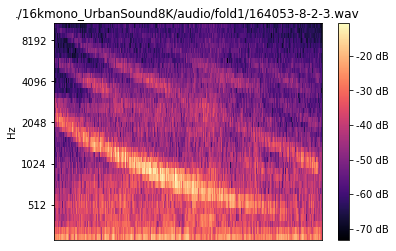

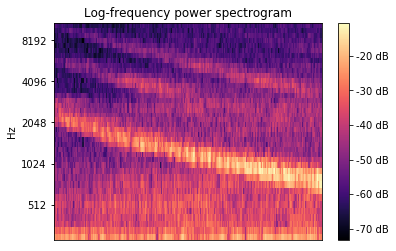

In [8]:
# Test
all_unifiles = [f.replace(ORGDATADIR, DATADIR) for f in all_files]

x, sr = librosa.load(all_unifiles[1])
mels = wavfile_to_melspectrogram(all_unifiles[0], debug_display=True)
display.display(display.Audio(mels, rate=sr))
mels2 = mels_get_len_unified(mels, 256)
show_melspectrogram(mels2)

In [20]:
import pandas as pd

traindata = pd.read_csv(os.path.join('.', 'train_list.csv'))
valdata = pd.read_csv(os.path.join('.', 'validation_list.csv'))
testdata = pd.read_csv(os.path.join('.', 'test_list.csv'))

def convert_dataset_process1(pd_list):
    xylist = [(int(pd_list.classID[k]), os.path.join(DATADIR, 'audio/fold%d/%s' % (pd_list.fold[k], pd_list.slice_file_name[k])))
                            for k in range(len(pd_list))]
    Xs = [wavfile_to_melspectrogram(xy[1]) for xy in xylist]
    ys = np.array([xy[0] for xy in xylist])
    return Xs, ys

def convert_dataset_process2(Xss):
    uni_length = get_max_mels_length(flatten_list(Xss))
    return [np.array([mels_get_len_unified(x, uni_length) for x in Xs]) for Xs in Xss]

X_train, y_train = convert_dataset_process1(traindata)
X_valid, y_valid = convert_dataset_process1(valdata)
X_test, y_test = convert_dataset_process1(testdata)
X_train, X_valid, X_test = convert_dataset_process2([X_train, X_valid, X_test])

In [21]:
X_train.shape, X_valid.shape, X_test.shape, y_train, y_valid, y_test

((5969, 40, 552),
 (990, 40, 552),
 (936, 40, 552),
 array([3, 3, 3, ..., 2, 2, 2]),
 array([3, 9, 9, 9, 9, 9, 9, 3, 3, 3, 7, 7, 7, 7, 8, 9, 9, 9, 9, 9, 9, 3,
        3, 3, 3, 3, 1, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 9, 9, 9, 9, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 6, 3, 3, 3, 3, 6, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8

In [22]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_valid.npy', X_valid)
np.save('y_valid.npy', y_valid)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

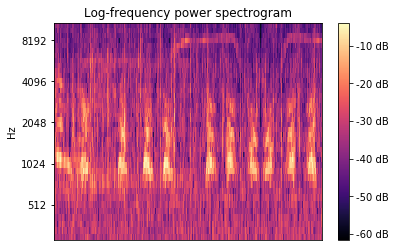

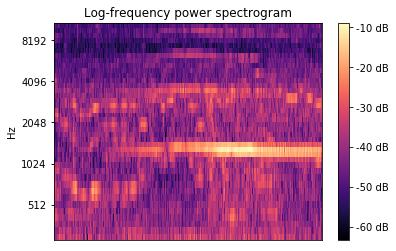

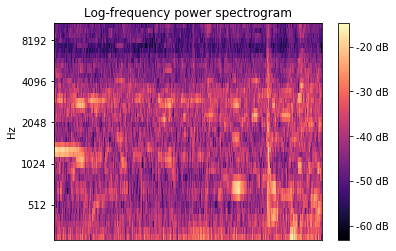

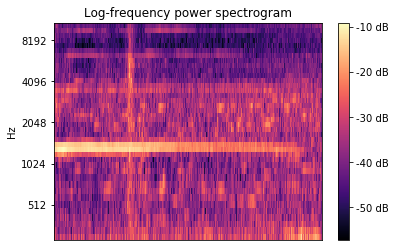

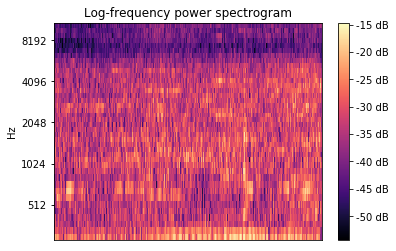

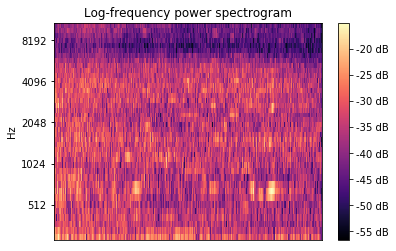

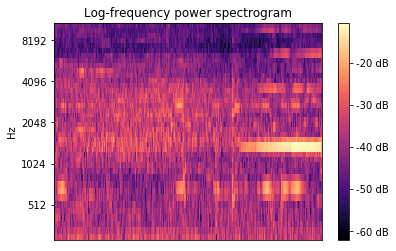

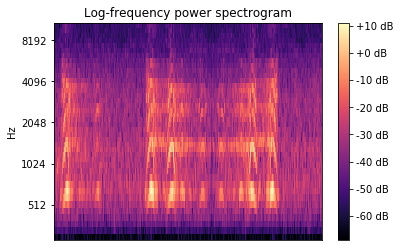

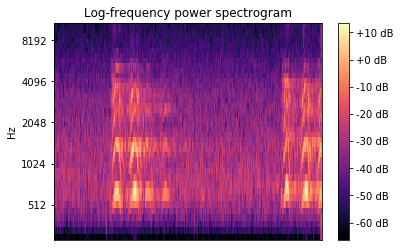

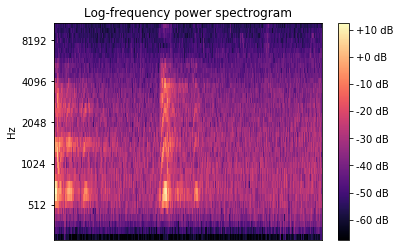

In [23]:
for mels in X_valid[:10]:
    show_melspectrogram(mels)
    plt.show()

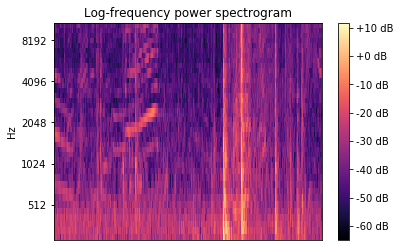

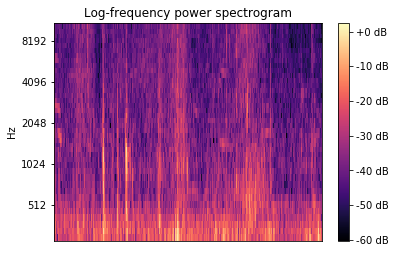

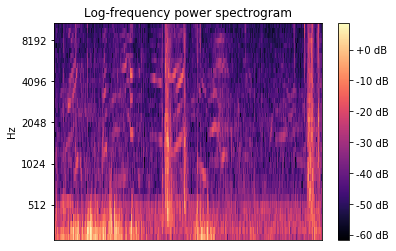

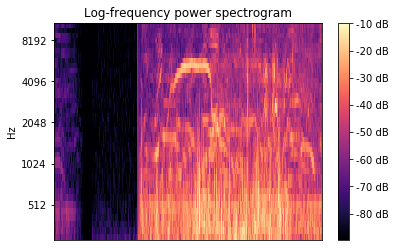

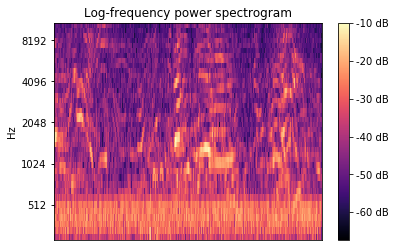

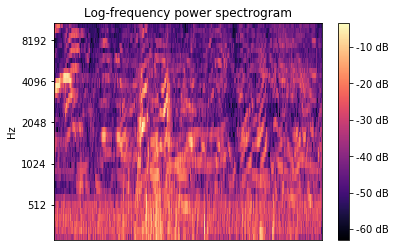

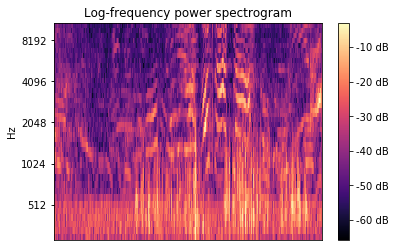

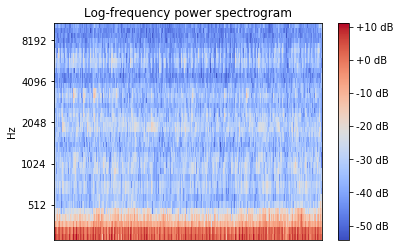

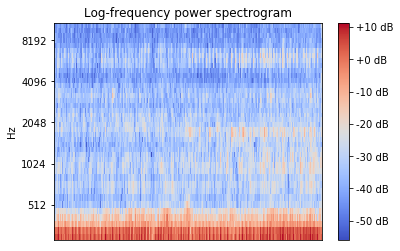

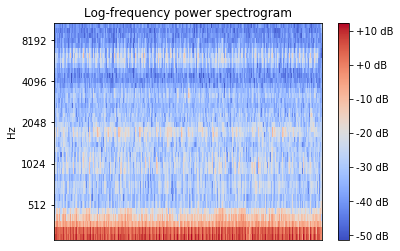

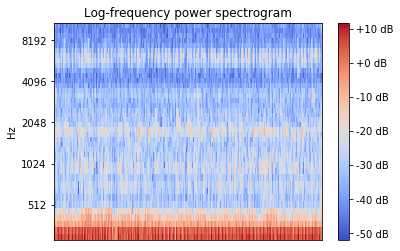

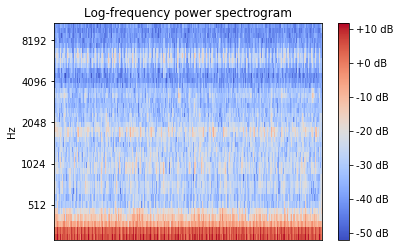

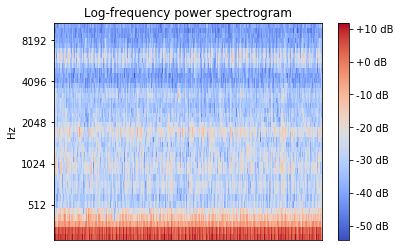

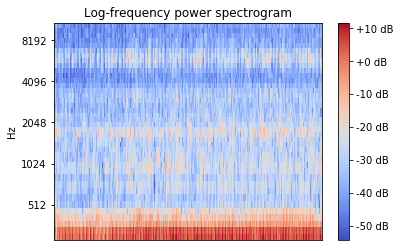

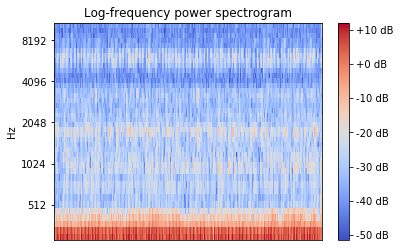

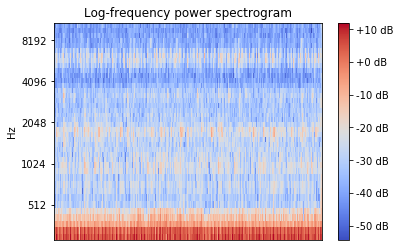

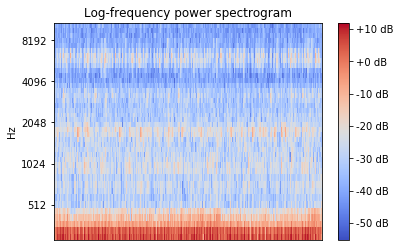

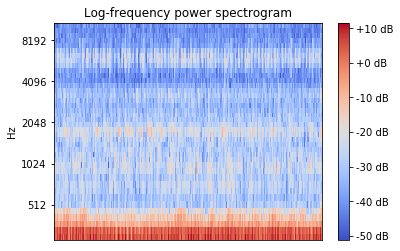

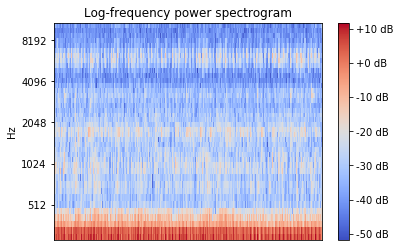

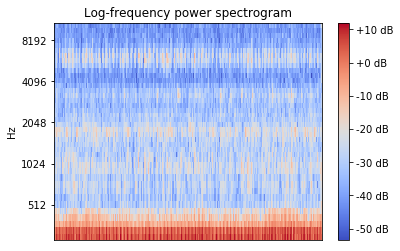

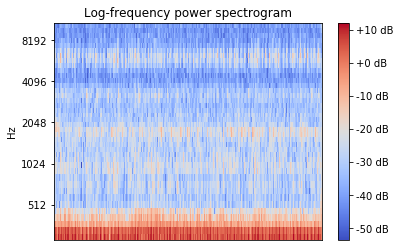

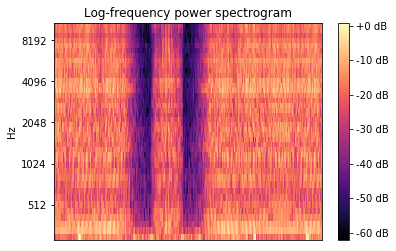

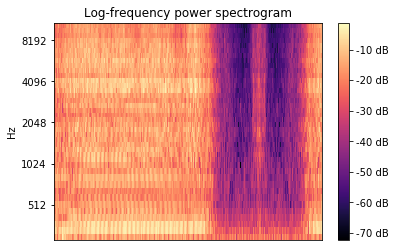

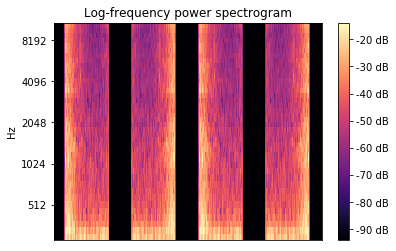

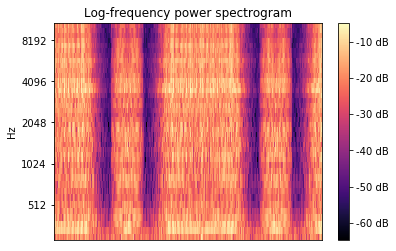

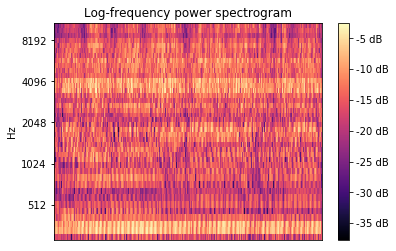

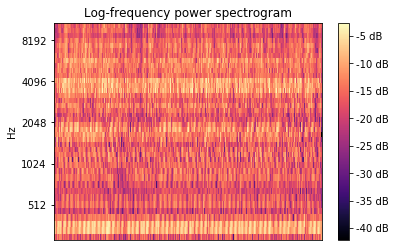

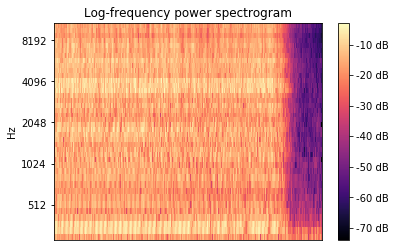

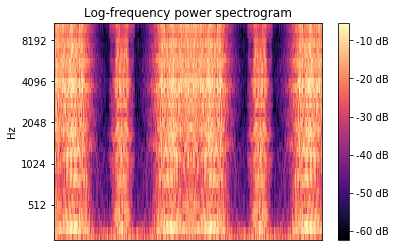

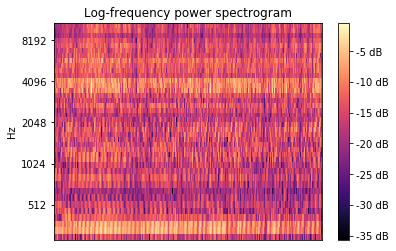

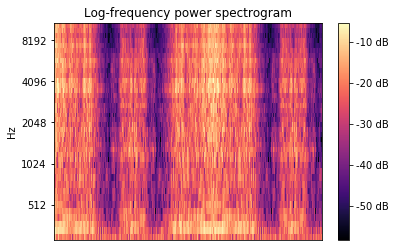

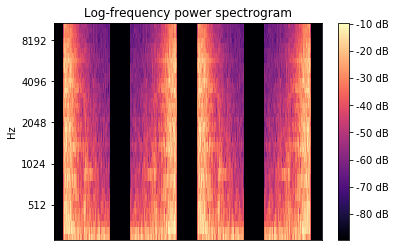

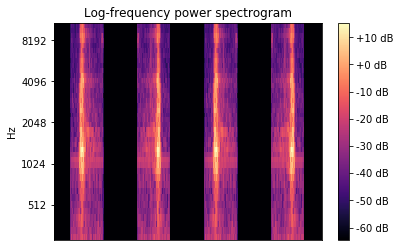

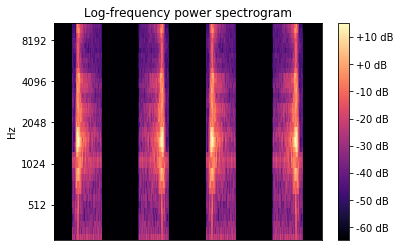

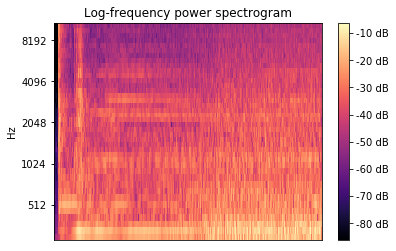

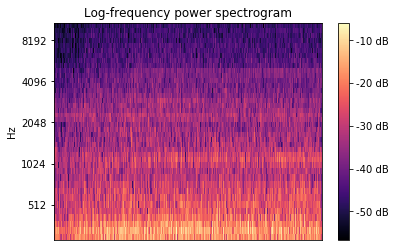

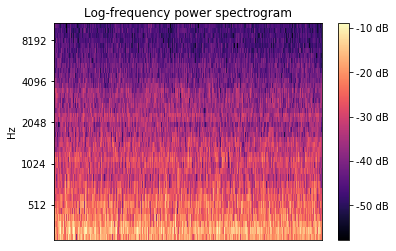

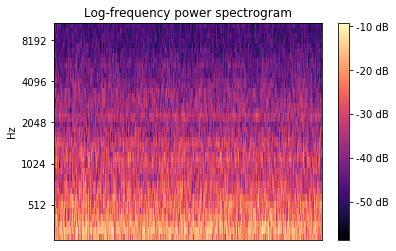

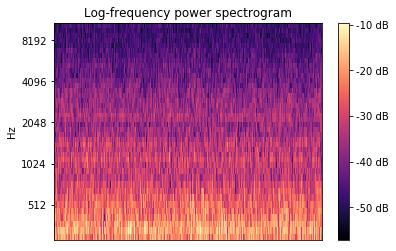

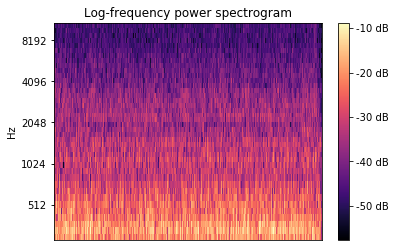

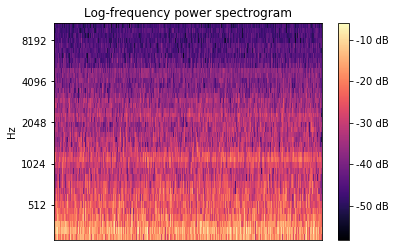

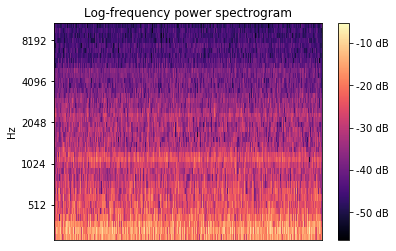

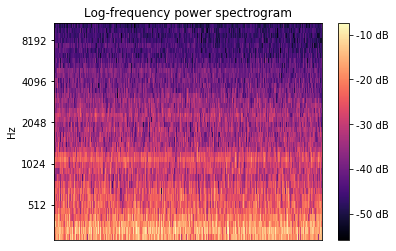

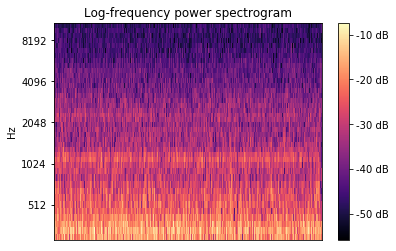

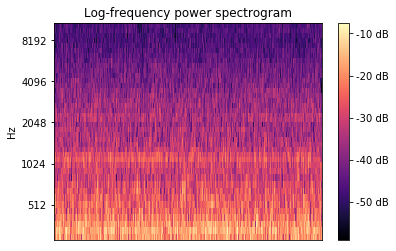

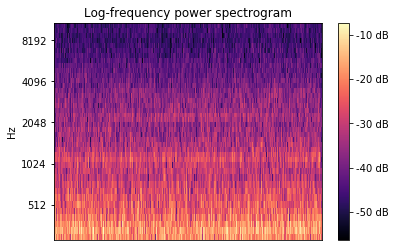

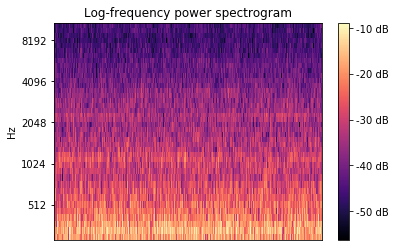

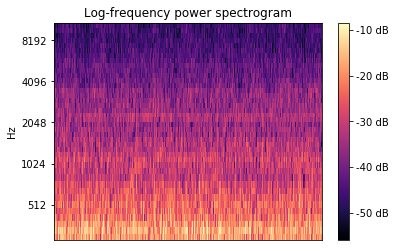

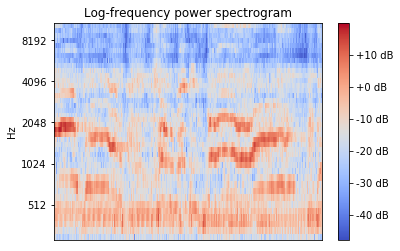

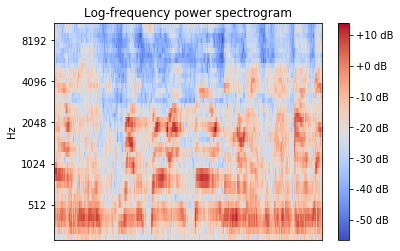

In [24]:
n = 50
start = 200
for mels in X_train[start:start + n]:
    show_melspectrogram(mels)
    plt.show()